# Convolutional Neural Networks: Application


实现一个非常简单的 卷积神经网络。 识别手势表示的数字。

大致的流程：
1. 准备数据，数值normalize，修正shape
2. 构建卷积神经网络结构（tensorflow中的graph）：目标函数（这里指最终输出），损失函数（指需要优化的对象）
3. 使用 SGD方法， mini-batch 训练模型


有一个严重的问题： 在Coursera上面运行的结果与在本地环境运行的结果不一致。并且本地训练的效果也非常差。

## 1 - 准备数据


In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops

%matplotlib inline
np.random.seed(1)

/home/yangdong/Applications/miniconda3/envs/DL3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Run the next cell to load the "SIGNS" dataset you are going to use.

In [2]:
def load_dataset():
    train_dataset = h5py.File('datasets/train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y


In [3]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

y = 1


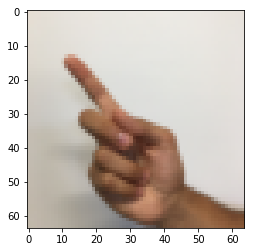

In [4]:
# Example of a picture
index = 8
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

In [5]:
X_train = X_train_orig/255.
X_test = X_test_orig/255.
Y_train = convert_to_one_hot(Y_train_orig, 6)
Y_test = convert_to_one_hot(Y_test_orig, 6)
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))
conv_layers = {}

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


## 2 构建神经网络结构


In [6]:

def create_model(n_H0, n_W0, n_C0, n_y):
    X = tf.placeholder(tf.float32, shape=(None, n_H0, n_W0, n_C0))
    Y = tf.placeholder(tf.float32, shape=(None, n_y))
    
#     tf.set_random_seed(1)   
    W1 = tf.get_variable("W1", [4, 4, 3, 8], initializer=tf.contrib.layers.xavier_initializer())
    W2 = tf.get_variable("W2", [2, 2, 8, 16], initializer=tf.contrib.layers.xavier_initializer())
    
    # forward propagation
    # CONV2D: stride of 1, padding 'SAME'
    Z1 = tf.nn.conv2d(X, W1, strides = [1,1,1,1], padding = 'SAME')
    # RELU
    A1 = tf.nn.relu(Z1)
    # MAXPOOL: window 8x8, sride 8, padding 'SAME'
    P1 = tf.nn.max_pool(A1, ksize = [1,8,8,1], strides = [1,8,8,1], padding = 'SAME')
    # CONV2D: filters W2, stride 1, padding 'SAME'
    Z2 = tf.nn.conv2d(P1, W2, strides = [1,1,1,1], padding = 'SAME')
    # RELU
    A2 = tf.nn.relu(Z2)
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 = tf.nn.max_pool(A2, ksize = [1,4,4,1], strides = [1,4,4,1], padding = 'SAME')
    # FLATTEN
    P2 = tf.contrib.layers.flatten(P2)
    # FULLY-CONNECTED without non-linear activation function (not not call softmax).
    # 6 neurons in output layer. Hint: one of the arguments should be "activation_fn=None" 
    Z3 = tf.contrib.layers.fully_connected(P2, 6, activation_fn=None)
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = Z3, labels = Y))
    parameters = {'W1': W1, 'W2': W2}
    
    return X, Y, Z3, cost, parameters


In [7]:
def random_mini_batches(X, Y, mini_batch_size = 64):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples) (m, Hi, Wi, Ci)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples) (m, n_y)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[0]                  # number of training examples
    mini_batches = []
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:,:,:]
    shuffled_Y = Y[permutation,:]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:,:,:]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:,:,:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [8]:
# GRADED FUNCTION: model

def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.009,
          num_epochs = 100, minibatch_size = 64, print_cost = True):
    """
    Implements a three-layer ConvNet in Tensorflow:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X_train -- training set, of shape (None, 64, 64, 3)
    Y_train -- test set, of shape (None, n_y = 6)
    X_test -- training set, of shape (None, 64, 64, 3)
    Y_test -- test set, of shape (None, n_y = 6)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    train_accuracy -- real number, accuracy on the train set (X_train)
    test_accuracy -- real number, testing accuracy on the test set (X_test)
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of the correct shape
    X, Y, Z3, cost, parameters = create_model(n_H0, n_W0, n_C0, n_y)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost.
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    init = tf.global_variables_initializer()
     
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(num_epochs):
            epoch_cost = 0.  
            permutation = list(np.random.permutation(m))
            shuffled_X = X_train[permutation, :]
            shuffled_Y = Y_train[permutation, :]  
            for i in range(0, m, minibatch_size):
                minibatch_X = shuffled_X[i:i+minibatch_size, :]
                minibatch_Y = shuffled_Y[i:i+minibatch_size, :]
                
                _ , minibatch_cost = sess.run([optimizer, cost], 
                                              feed_dict={X: minibatch_X, Y: minibatch_Y})
                
                epoch_cost += minibatch_cost * minibatch_X.shape[0] / m

            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 10 == 0:
                costs.append(minibatch_cost)
        
        
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # save parameters
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")
        
        # Calculate the correct predictions
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters

Cost after epoch 0: 1.769335
Cost after epoch 100: 0.129816
Cost after epoch 200: 0.282884
Cost after epoch 300: 0.098827
Cost after epoch 400: 0.014825


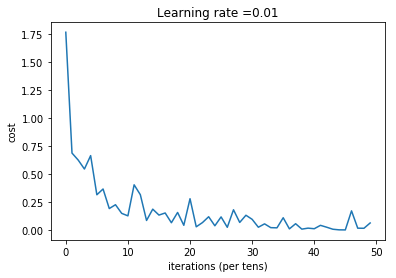

Parameters have been trained!
Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 1.0
Test Accuracy: 0.85


In [10]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test, learning_rate=0.01, num_epochs=500)

**Expected output**: although it may not match perfectly, your expected output should be close to ours and your cost value should decrease.

<table> 
<tr>
    <td> 
    **Cost after epoch 0 =**
    </td>

    <td> 
      1.917929
    </td> 
</tr>
<tr>
    <td> 
    **Cost after epoch 5 =**
    </td>

    <td> 
      1.506757
    </td> 
</tr>
<tr>
    <td> 
    **Train Accuracy   =**
    </td>

    <td> 
      0.940741
    </td> 
</tr> 

<tr>
    <td> 
    **Test Accuracy   =**
    </td>

    <td> 
      0.783333
    </td> 
</tr> 
</table>

与之前的非CNN 神经网络相比，这里训练的效果很好（在400epoch 就达到0.001的loss水平），但问题是过拟合了。对测试数据的效果并不友好。

另外，相比简单的网络，这里的训练时间有点长。

才896个参数而已？？这是为什么

In [73]:
s = 0
for p in parameters.values():
    s += np.prod(p.shape)
print(s)

896


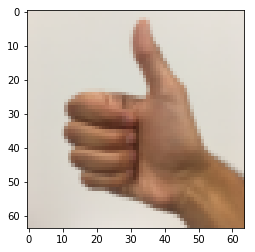

In [22]:
fname = "images/thumbs_up.jpg"
image = np.array(ndimage.imread(fname, flatten=False))
my_image = scipy.misc.imresize(image, size=(64,64))
plt.imshow(my_image)